## 손실 곡선
fit() 메서드로 모델을 훈련할 때 출력의 마지막에 다음과 같은 메시지가 나왔다

<tensorflow.python.keras.callbacks.History at 0x8f824ad9f080>

주피터 노트북의 코드 셀은 마지막 라인의 실행 결과를 자동으로 출력한다. 즉 fit() 메서드가 무엇인가를 반환한다는 의미다. fit() 메서드는 History 클래스 객체를 반환하는데, 이 객체에는 훈련 과정에서 계산한 지표, 다시 말해 손실과 정확도 값이 저장되어있다. 이 값을 사용해서 그래프를 그려보자

In [1]:
# 패션 MNIST 데이터 적재 및 훈련셋 검증셋 나누기
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

# 모델을 만드는 함수
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

# model_fn 모델 구조
model = model_fn()
model.summary()

4431872/4422102 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [2]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

여기에서 verbose는 훈련 과정 출력을 조절한다. 기본값은 1로 에폭마다 진행 막대와 함께 손실 등의 지표가 출력된다. 2로 바꾸면 진행 막대를 빼고 출력된다. 이번에는 훈련 결과를 그래프로 나타내고 verbose를 0으로 지정하여 훈련 과정을 나타내지 않았다

In [3]:
# history 딕셔너리 속성값 확인
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


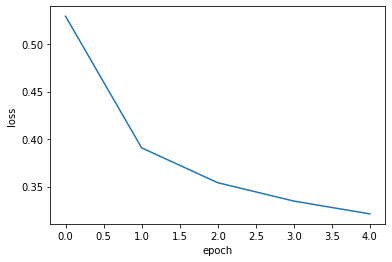

In [4]:
# 그래프 - loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

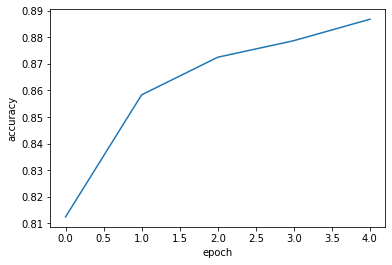

In [5]:
# 그래프 - accuracy
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

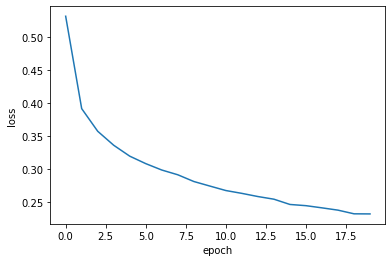

In [6]:
# 모델 훈련 - 20 에폭 돌리기
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


## 검증 손실
에폭에 따른 오버 언더피팅을 파악하려면 훈련셋에 대한 점수뿐만 아니라 검증셋에 대한 점수도 필요하다. 손실에 대한 두 점수를 견주었을 때 훈련셋과 검증셋의 점수의 차가 커질 때 오버피팅이라고 생각할 수 있기 때문이다. 이 장에서는 손실을 사용해 오버/언더피팅을 다뤄본다
> 참고
- 인공 신경망이 모델을 최적화하는 대상은 정확도가 아닌 손실함수다. 따라서 모델이 잘 훈련되었는지 판단하려면 정확도보다는 손실 함수의 값을 확인하는 것이 더 낫다

In [7]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [8]:
# history의 딕셔너리 값 확인
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


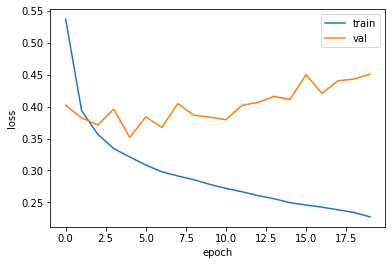

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

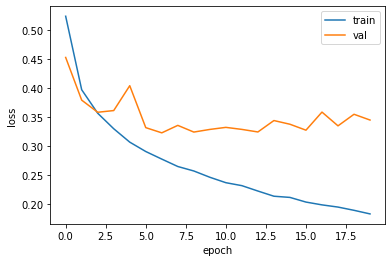

In [10]:
# optimizer를 adam으로 바꾸어 훈련
model=model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 드롭 아웃
**드롭 아웃(drop out)**은 훈련 과정에서 층에 있는 일부 뉴런의 출력을 0으로 만들어 오버피팅을 막는 기법이다. 오버피팅을 막는 이유는 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 대해 주의를 기울여야 하기 때문이다. 또 다른 해석은 일부 뉴런의 출력을 0으로 만든 여러 신경망을 앙상블로 보아 오버피팅을 막았다는 것이다

앞에서 정의한 model_fn에 드롭 아웃 객체를 전달해 층을 추가해보자. 어떤 층의 뒤에 드롭 아웃을 두어 그 층의 출력을 랜덤하게 0으로 만드는 것으로, 드롭 아웃 층의 자체 파라미터는 없다

In [11]:
# 30% 드롭 아웃
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


위와 같이 드롭 아웃 층은 자체 파라미터가 없고, 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지 않는다. 또한 훈련이 끝난 후에는 훈련된 모든 뉴런을 사용해야하기 때문에 드롭 아웃을 적용하지 않아야한다. 하지만 모델을 훈련한 뒤 평가와 예측에 사용할 때는 케라스가 알아서 드롭 아웃을 적용하지 않기 때문에 따로 층을 빼거나 할 필요는 없다

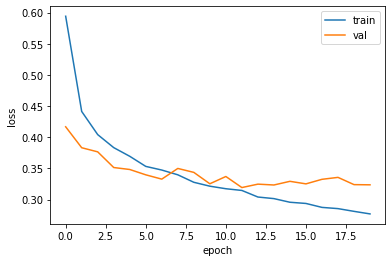

In [12]:
# 드롭 아웃을 적용하여 훈련
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원
위의 모델은 20에폭을 돌렸기 때문에 약간 오버피팅이 되어있다고 할 수 있다. 따라서 10에폭으로 축소하고 모델을 저장해보자

케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weights() 메서드를 제공한다. 기본적으로 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 .h5면 HDF5 포맷으로 저장한다. 또한 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공한다. 기본적으로 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 .h5일 경우 HDF5 포맷으로 저장한다

In [13]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

In [14]:
model.save_weights('model-weights.h5')
model.save('model-whole.h5')

!ls -al *.h5

-rw-r--r-- 1 root root 333448 Dec 27 13:34 model-weights.h5
-rw-r--r-- 1 root root 982664 Dec 27 13:34 model-whole.h5


In [15]:
# 실험1: 훈련 하지 않은 새로운 모델을 만들고 model-weights.h5
#       파일에서 훈련된 모델 파라미터를 읽어서 사용
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8825833333333334


In [16]:
# 실험2: model-whole.h5에서 새로운 모델을 만들어 바로 사용
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3332 - accuracy: 0.8826


[0.3331752121448517, 0.8825833201408386]

두 실험 모두 같은 결과를 냈다. 첫 번째 실험에서는 predict() 메서드를 사용해 검증셋을 테스트했다. predict는 샘플마다 10개의 클래스에 대한 확률을 반환한다. 따라서 argmax() 메서드를 사용해 10개의 클래스 중 가장 높은 확률에 대한 인덱스를 반환하도록 했다. axis에 -1을 넣은 건 배열의 마지막 차원을 따라 최댓값을 구한다는 의미인데, 여기서는 2차원이므로 axis는 자동으로 1이 되고 열 마다의 최댓값을 계산한다. 두 번째 실험에서는 evaluate() 메서드를 이용해서 테스트했는데, evaluate는 쉽게 정확도를 계산해준다. 이때 첫 실험에서 evaluate를 사용하지 못한 이유는 손실을 계산하기 위해서 compile() 메서드를 무조건 실행해야 하기 때문이다. 두 번째 실험은 모델 구조와 옵티마이저 상태까지 모두 복원하기 때문에 evaluate() 메서드를 사용할 수 있다

위에서는 20에폭을 돌린 후 오버피팅이 되는 것을 확인하고 10에폭으로 축소해서 돌렸다. 케라스의 콜백을 사용하면 이 훈련을 한 번에 끝낼 수 있다

## 콜백
**콜백(callback)**은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들이고, fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다. 여기에서 사용할 ModelCheckpoint 콜백은 기본적으로 에폭마다 모델을 저장한다. save_best_only 매개변수를 True로 지정하면 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다

In [18]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

# 최상의 검증 점수를 낸 best-model.h5 모델로 예측 수행
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3184 - accuracy: 0.8898


[0.3184126019477844, 0.8898333311080933]

ModelCheckpoint 콜백이 가장 낮은 점수의 모델을 자동으로 저장해주지만 여전이 20에폭을 돌린다. 검증 점수가 상승하면 이후에는 오버피팅이 더 커지기 때문에 훈련을 계속할 필요가 없다. 이렇게 오버피팅이 되기 전에 훈련을 미리 중지시키는 것을 **조기 종료(early stopping)**라고 부른다. 케라스에는 EarlyStopping 콜백을 제공한다. patience 매개변수로 검증 점수가 향상되지 않더라도 참을 에폭 횟수를 지정하고, restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다. 이 콜백과 앞의 ModelCheckpoint 콜백을 함께 사용해보자

7


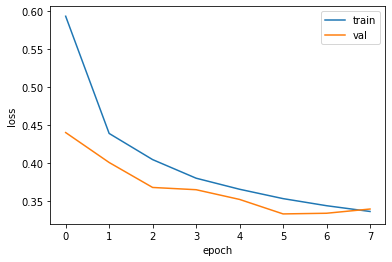

In [19]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, 
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb, early_stopping_cb])

# 돌린 에폭 횟수
print(early_stopping_cb.stopped_epoch)

# 훈련 손실과 검증 손실
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [20]:
# 조기 종료 성능 확인
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3328 - accuracy: 0.8764


[0.33281275629997253, 0.8764166831970215]

In [22]:
test_scaled = test_input / 255.0
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 4ms/step - loss: 0.3649 - accuracy: 0.8691


[0.364921510219574, 0.8690999746322632]